In [1]:
def encode(df):
    le = preprocessing.LabelEncoder()
    le.fit(df)
    return(le.transform(df))



In [2]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 999

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
offline.init_notebook_mode(connected=True)
import plotly.express as px

from mpl_toolkits.axes_grid1 import make_axes_locatable
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns



# For changes in .py
%reload_ext autoreload
%autoreload 2

import numpy as np

import missingno as msno

stats = ['skew', 'mad', 'kurt']


import qgrid

def qg(df):
    return(qgrid.show_grid(df,show_toolbar=True, grid_options={'forceFitColumns': False}))

import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', 100)

import requests
import json
import xmltodict
import re
import urllib.request as urllib2
import io
import yaml

import math
import pysal as ps

# from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks



import imageio


from sklearn import preprocessing


Populating the interactive namespace from numpy and matplotlib


In [3]:
def clean(df, ano):
    df = df.drop(columns=['Unnamed: 16'])
    df.columns = pd.Series(df.columns).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ','_').str.lower().str.strip().tolist()    
    mask = df['orgao'].notnull()
    df = df[mask]
    
    for col in df.columns[-6:]:
        df[col] = df[col].str.replace('.','').str.replace(',','.')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    categoria = {
        '3' :  'DESPESAS CORRENTES',
        '4' :  'DESPESAS DE CAPITAL',
        '9' :  'RESERVA DE CONTINGENCIA',
    }
    
    df['categoria'] = df['elemento'].apply(lambda x: x[:1]).replace(categoria)

    
    grupo = {
        '31' : 'PESSOAL E ENCARGOS SOCIAIS',
        '32' : 'JUROS E ENCARGOS DA DIVIDA',
        '33' : 'OUTRAS DESPESAS CORRENTES',
        '44' : 'INVESTIMENTOS',
        '45' : 'INVERSOES FINANCEIRAS',
        '46' : 'AMORTIZACAO DE DIVIDA',
        '99' : 'RESERVA DE CONTINGENCIA'
    }
    
    df['grupo'] = df['elemento'].apply(lambda x: x[:2]).replace(grupo)
    
    modalidade = {
        '3120' :  'TRANSFERENCIAS A UNIAO',
        '3190' :  'APLICACOES DIRETAS',
        '3191' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIA',
        '3290' :  'APLICACOES DIRETAS',
        '3291' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '3320' :  'TRANSFERENCIAS A UNIAO',
        '3340' :  'TRANSFERENCIAS A MUNICIPIOS',
        '3341' :  'TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO',
        '3350' :  'TRANSF.A INST.PRIVADAS SEM FINS LUCRATIVOS',
        '3360' :  'TRANSF.A INST.PRIVADAS COM FINS LUCRATIVOS',
        '3367' :  'EXECUCAO DE CONTRATO DE PPP',
        '3370' :  'TRANSF.A INSTIT.MULTIGOVERN.NACIONAIS',
        '3380' :  'TRANSFERENCIAS AO EXTERIOR',
        '3390' :  'APLICACOES DIRETAS',
        '3391' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4420' :  'TRANSFERENCIAS A UNIAO',
        '4440' :  'TRANSFERENCIAS A MUNICIPIOS',
        '4450' :  'TRANSF.A INSTIT.PRIVADAS SEM FINS LUCRATIVOS',
        '4490' :  'APLICACOES DIRETAS',
        '4491' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4567' :  'EXECUCAO DE CONTRATO DE PPP',
        '4590' :  'APLICACOES DIRETAS',
        '4591' :  'APLIC.DIRETAS-OP.ENTRE ENTID.INTEGR.ORCAMENT',
        '4690' :  'APLICACOES DIRETAS',
        '4691' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '9999' :  'RESERVA DE CONTINGENCIA',

    }
    
    df['modalidade'] = df['elemento'].apply(lambda x: x[:4]).replace(modalidade)

    
    
    return(df)

In [14]:
ano = '2018'

df = pd.read_csv('../data/orcamento_{}.csv'.format(ano), encoding="ISO-8859-9")

df_18 = clean(df,ano)
df_18['elemento'] = df_18['elemento'].str.split('-').apply(lambda x: x[1]).str.strip()
df_18['orgao'] = df_18['orgao'].str.split('-').apply(lambda x: x[1]).str.strip()




In [17]:
mask = df_18['orgao']=='TRIBUNAL DE JUSTICA'
df_18 = df_18[mask]

In [18]:
# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','fonte_de_recursos','grupo']
target = ['fonte_de_recursos','grupo','elemento']
valor  = 'empenhado'


cols = source + target
cols = list(set(cols))

df_sankey = df_18.groupby(by = cols, as_index=False, sort=False).sum()[cols + [valor]]
color = '#300101'

df_sankey = df_sankey.sort_values(by=cols)

In [19]:
df_final = pd.DataFrame()

for i in range(len(source)):
    df_aux = pd.DataFrame()
    
    print(source[i], target[i])
    
    
    df_aux['source'] = df_sankey[source[i]]
    df_aux['target'] = df_sankey[target[i]]
    df_aux['value']  = df_sankey[valor]
    df_final = pd.concat([df_final,df_aux], axis=0)

orgao fonte_de_recursos
fonte_de_recursos grupo
grupo elemento


In [20]:
label = df_final['source'].tolist() + df_final['target'].tolist()
# value = df_sankey['orgaos_count'].tolist() + df_sankey['grupo_count'].tolist()
df = pd.DataFrame(label,columns = ['label'])
# df['number'] = value
df = df.drop_duplicates(subset='label', keep='first')
df['number'] = [i for i in range(len(df))]

In [21]:
df_final = pd.merge(df_final,df, left_on = ['source'], right_on=['label'], how = 'left', suffixes=('_orgao','_bla') ).rename(columns = {'number':'source_num'})
df_final = pd.merge(df_final,df, left_on = ['target'], right_on=['label'], how = 'left', suffixes=('_orgao','_bla') ).rename(columns = {'number':'target_num'})


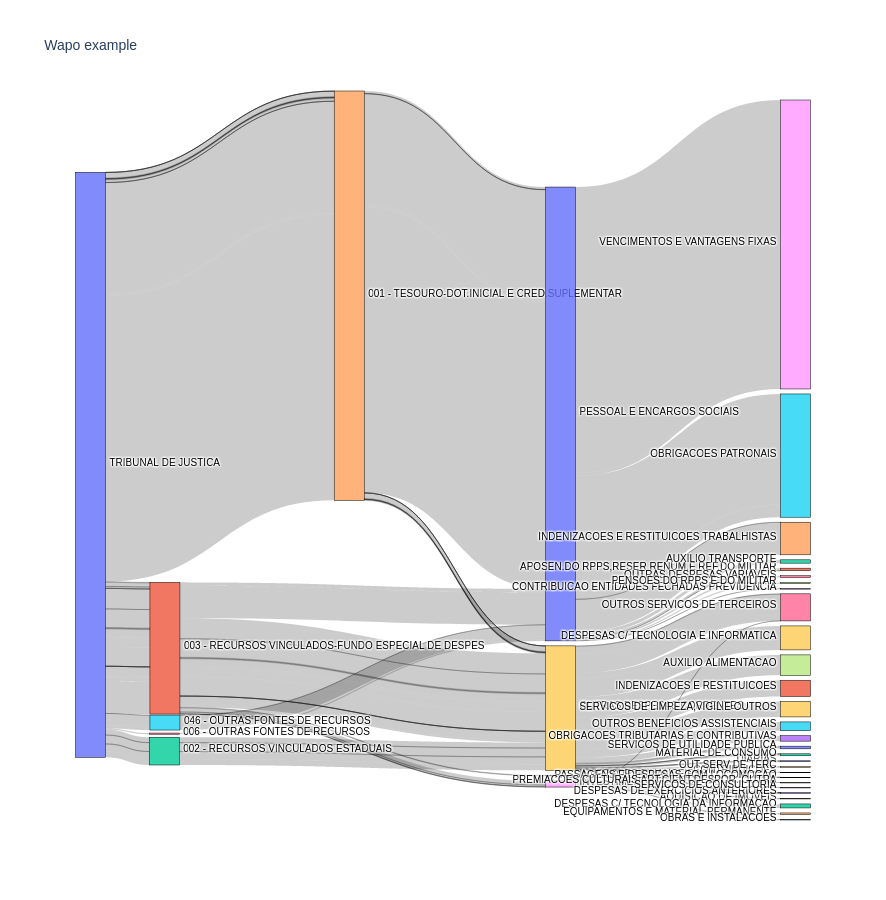

In [22]:
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
#     valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  df['label']
    ),
    link = dict(
      source = df_final['source_num'],
      target = df_final['target_num'],
      value = df_final['value'],
#       label =  df['label']
  )
)

layout =  dict(
    title = "Wapo example",
    height = 900,
    width = 1200,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
iplot(fig)

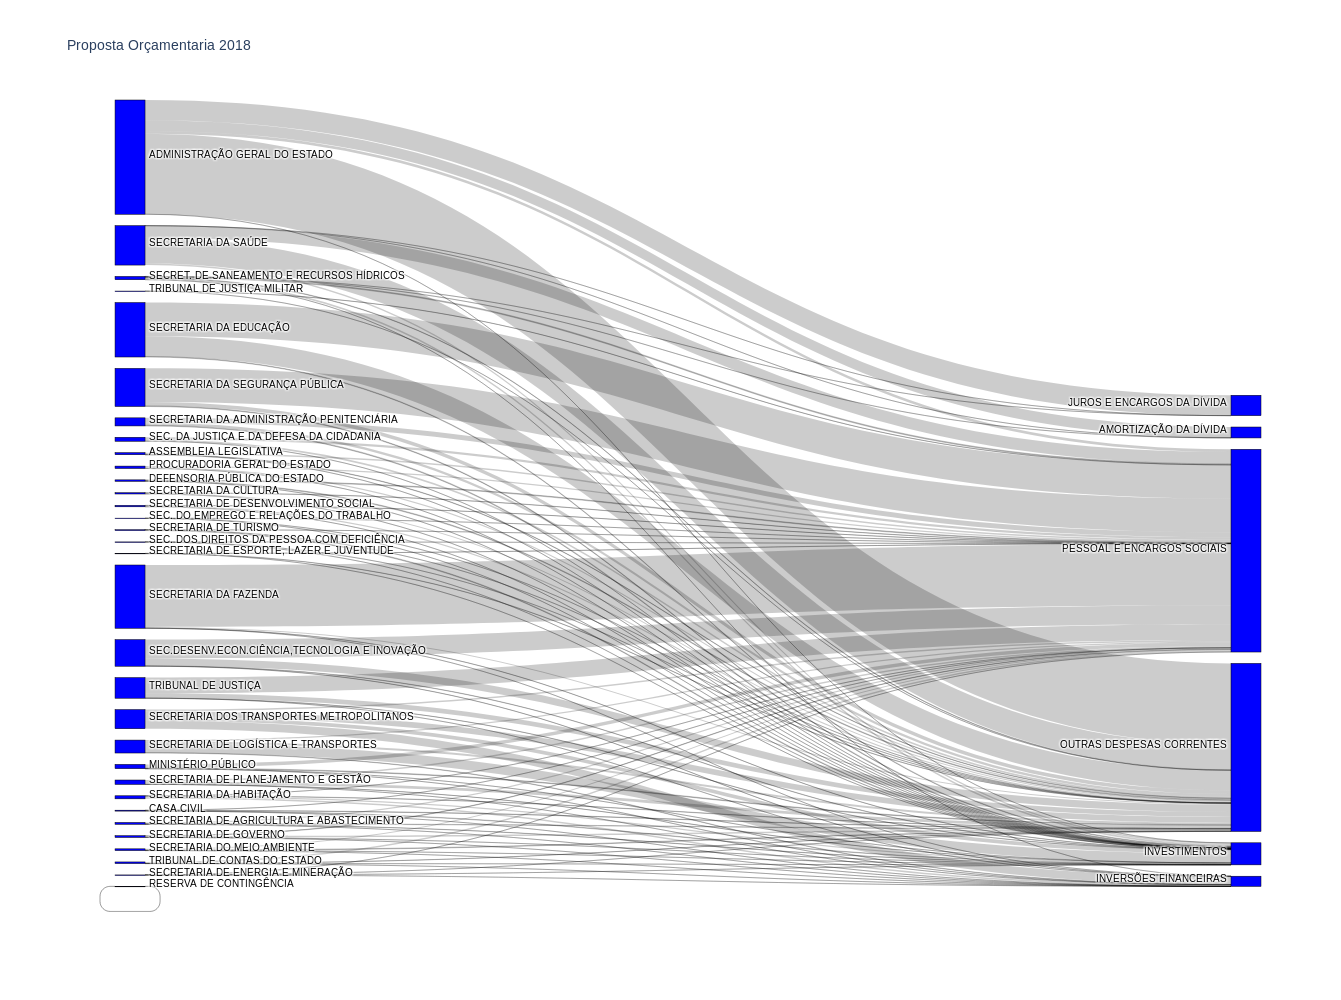

In [9]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = df['label'],
      color = "blue"
    ),
    link = dict(
      source = df_sankey['num_org'], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = df_sankey['num_grupo'],
      value = df_sankey['valor']
  ))])

layout =  dict(
    title = "Proposta Orçamentaria 2018",
    height = 1000,
#     width = 1400,
    font = dict(
      size = 10
    ),    
)


fig.update_layout(layout)
fig.show()

In [104]:
import json, urllib
import chart_studio.plotly as py
import pandas as pd
import numpy as np

In [105]:
url = 'https://rawgit.com/monfera/plotly-webgl-parcoords/sankey-example-01/drones.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

In [106]:
label = []
for x in data['data'][0]['nodes']:
    label.append(x['label'])
    
    
linkSource = []
linkValue = []    
linkTarget = []
linkLabel = []
for x in data['data'][0]['links']:
    linkLabel.append(x['label'])
    linkSource.append(x['source'])
    linkValue.append(x['value'])
    linkTarget.append(x['target'])

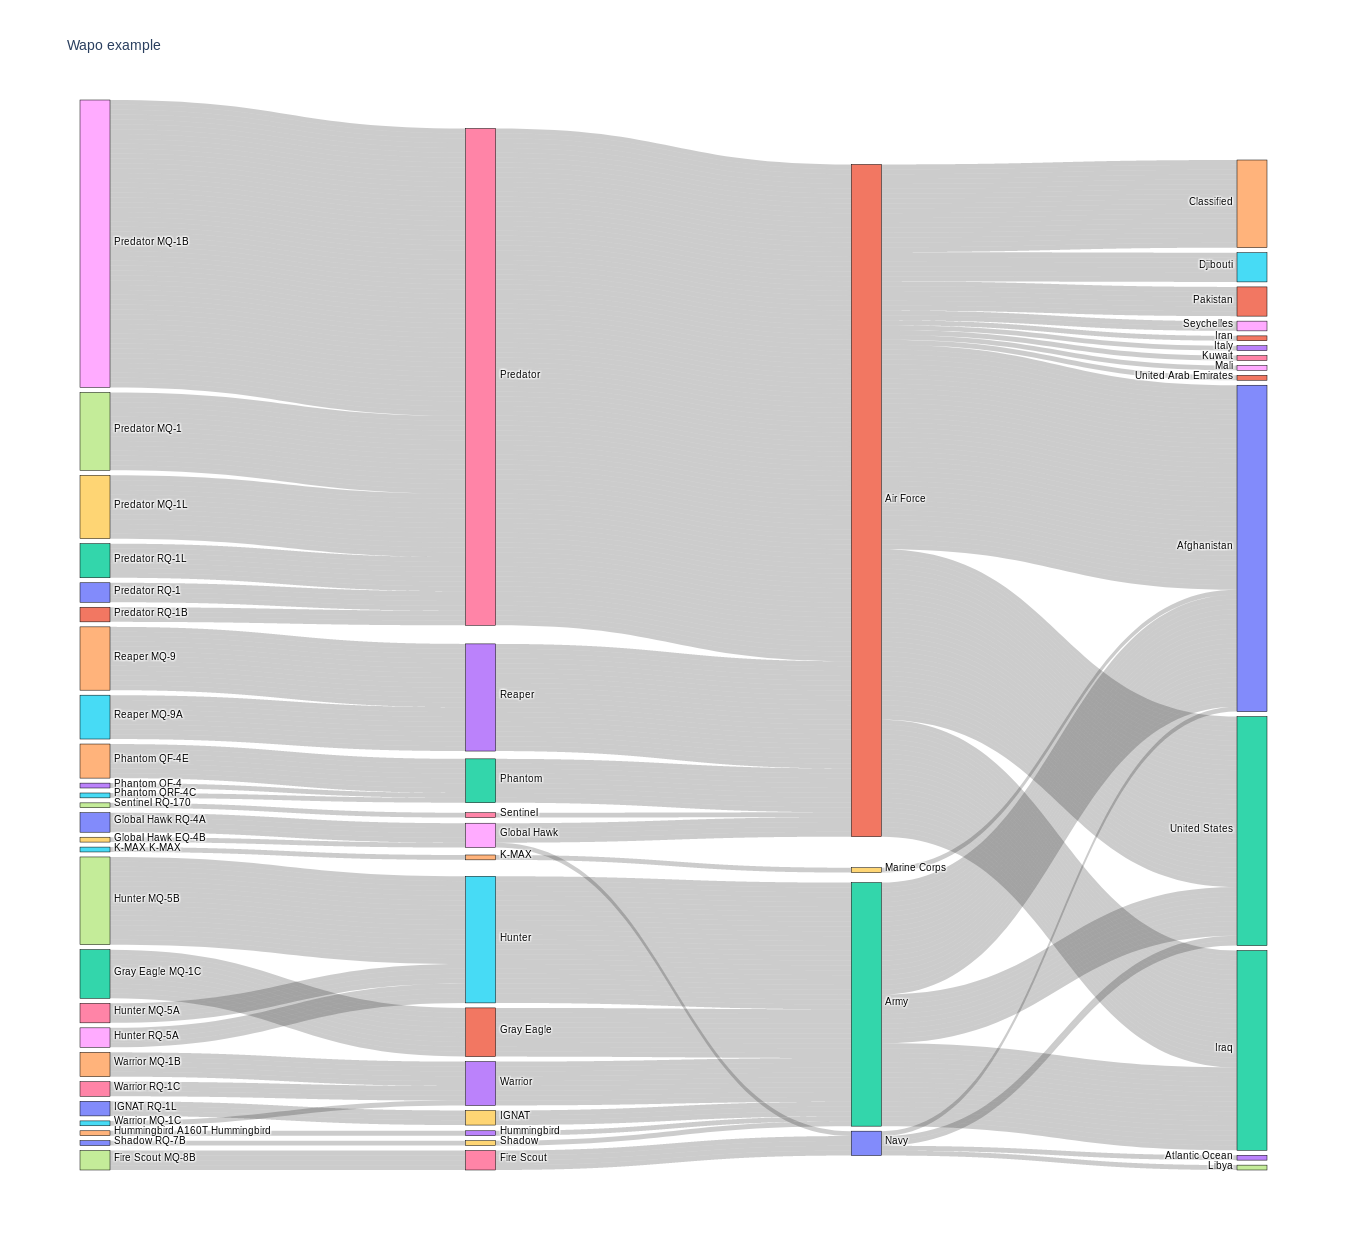

In [108]:
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  label
    ),
    link = dict(
      source = linkSource,
      target = linkTarget,
      value = linkValue,
      label =  linkLabel
  )
)

layout =  dict(
    title = "Wapo example",
    height = 1250,
    width = 1000,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
iplot(fig)

In [14]:
mask = df['Órgão'].notnull()
df = df[mask].drop(columns=['Unnamed: 16'])

In [19]:
for col in df.columns[10:]:
    df[col] = df[col].str.replace('.','').str.replace(',','.').astype(float)

In [ ]:
1.186.232.580

In [13]:
df = pd.read_csv('../orcamentos/orcamento_2018.csv', encoding='ISO-8859-9')

In [22]:
df.groupby(by='Órgão').sum().sum()

Dotação Inicial    2.459258e+11
Dotação Atual      2.538924e+11
Empenhado          2.420373e+11
Liquidado          2.420373e+11
Pago               2.250363e+11
Pago Restos        1.562613e+10
dtype: float64